# **Informe sobre la Implementación de un Sistema Distribuido para Estimar el Valor de $\pi$ utilizando ZeroC ICE y el Método de Monte Carlo**

### **Equipo:**
- Esteban Gaviria Zambrano - A00396019
- Jose Manuel Cardona - A00399980
- Juan Manuel Díaz - A00394477
- Juan Camilo Muñoz Barco - A00399199

### 1. **Introducción**

Este informe detalla el desarrollo de un sistema distribuido para calcular el valor de $\pi$ mediante el método de Monte Carlo. La solución emplea ZeroC ICE y sigue un modelo cliente-servidor con múltiples trabajadores para distribuir las tareas de cómputo. El propósito es mostrar cómo la estimación de $\pi$ puede distribuirse eficazmente entre diversos nodos, mejorando el rendimiento al aumentar el número de trabajadores.




### 2. **Descripción del Método de Monte Carlo para Estimar $\pi$**

El **método de Monte Carlo** es una técnica probabilística que permite estimar el valor de $\pi$ generando puntos aleatorios dentro de un cuadrado de lado 2 centrado en el origen (coordenadas $(-1, -1)$ a $(1, 1)$). Se compara cuántos de estos puntos caen dentro del círculo inscrito en ese cuadrado. Para entender mejor cómo funciona este método, a continuación se detalla el algoritmo paso a paso:

  - Se generan $N$ puntos aleatorios $(x, y)$ donde $x$ y $y$ son números entre $-1$ y $1$.
  - Se determina si cada punto cae dentro del círculo usando la condición: $x^2 + y^2 \leq 1$.
  - La proporción de puntos dentro del círculo respecto al total de puntos se aproxima a $\pi/4$.
  - La estimación de $\pi$ se obtiene mediante la fórmula:
    
$$ \pi \approx 4 \times \left(\frac{\text{número de puntos en el círculo}}{\text{total de puntos lanzados}}\right)$$


### 3. **Modelo Cliente-Maestro-Trabajadores**

El sistema distribuido se construyó utilizando el modelo cliente-maestro-trabajadores.

- **Cliente**: El Cliente actúa como la interfaz de usuario que solicita al sistema una estimación de $\pi$ y envía una solicitud al maestro con un número de puntos $N$ para ser utilizados en la estimación.
- **Maestro**: El Maestro coordina la distribución de las tareas entre un conjunto de trabajadores, dividiendo el número total de puntos $N$ entre $n$ trabajadores para que cada uno procese una parte de los puntos. Además, el maestro recoge los resultados de cada trabajador y calcula la estimación final de $\pi$.
- **Trabajadores**: Los Trabajadores reciben la tarea de generar un subconjunto de $N/n$ puntos y cuentan cuántos de ellos caen dentro del círculo, enviando de vuelta al maestro el número de puntos que caen dentro del círculo.




### 4. **Estrategia de Distribución de las Tareas entre los Trabajadores**

El maestro divide el total de puntos $N$ en $n$ partes aproximadamente iguales para que cada trabajador procese $N/n$ puntos. Cada trabajador genera puntos de forma independiente y calcula cuántos de esos puntos caen dentro del círculo. Las tareas se envían a los trabajadores de manera asíncrona utilizando ZeroC ICE, permitiendo que el maestro continúe con otras tareas mientras los cálculos se realizan. Una vez que todos los trabajadores completan sus tareas, el maestro recopila los resultados y suma el número total de puntos dentro del círculo. Finalmente, el maestro estima $\pi$ utilizando la fórmula descrita anteriormente.



#### **Diagrama de Clases** (Ver anexo 2):

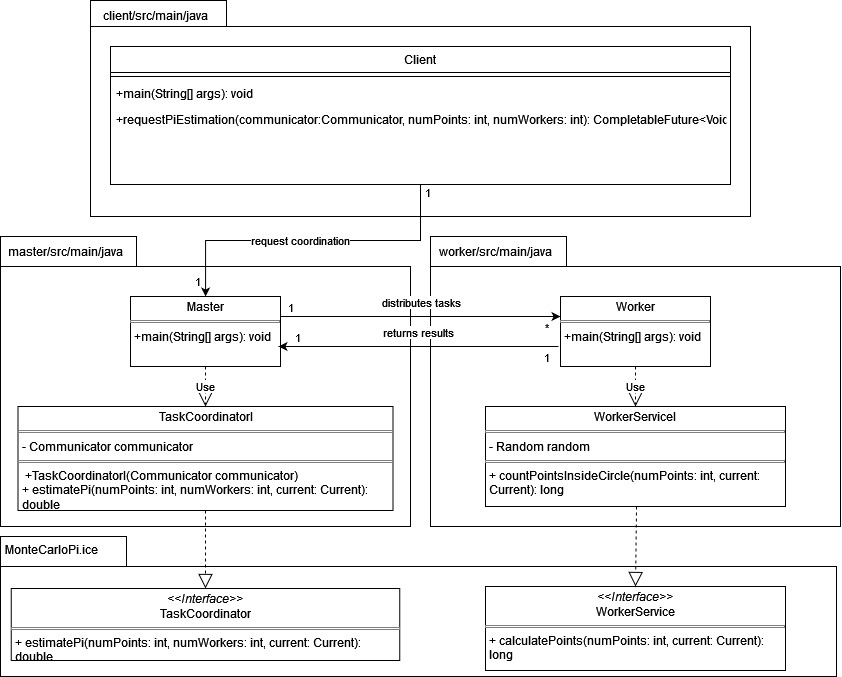

### 5. **Explicación del Código Fuente de la Implementación**

La implementación del sistema para estimar $\pi$ con el método de Monte Carlo utilizando ZeroC ICE se organiza en varias clases que cumplen roles específicos dentro del modelo cliente-maestro-trabajadores. A continuación, se describe en detalle lo que hace cada clase, así como algunos fragmentos clave del código para ilustrar su funcionamiento.

#### **Archivo `MonteCarloPi.ice`**

Este archivo define las interfaces necesarias para la comunicación entre los componentes del sistema distribuido. Se utiliza el lenguaje de definición de interfaces de ZeroC ICE, llamado Slice. En este caso, se definen dos interfaces: `WorkerService` y `TaskCoordinator`.

La interfaz `WorkerService` define el método `calculatePoints(int numPoints)`, que es asíncrono. Este método permite que cada trabajador reciba un número de puntos a generar y devuelva cuántos de esos puntos cayeron dentro de un círculo inscrito. Por otro lado, la interfaz `TaskCoordinator` expone el método `estimatePi(int numPoints, int numWorkers)`, también asíncrono. Este método permite coordinar la distribución de los cálculos entre los trabajadores y obtener la estimación final de $\pi$. A continuacion se muestra la definicion de estas interfaces:

```ice
module MonteCarloPi {
    interface WorkerService {
        ["async"] int calculatePoints(int numPoints);
    };

    interface TaskCoordinator {
        ["async"] float estimatePi(int numPoints, int numWorkers);
    };
};
```
Estas interfaces actúan como el contrato entre los nodos, asegurando que los métodos sean invocados de manera consistente a través de las distintas partes del sistema distribuido.

#### **Clase `WorkerServiceI.java`**

La clase WorkerServiceI implementa la interfaz WorkerService y define la lógica para contar cuántos puntos caen dentro de un círculo, utilizada en la estimación de π mediante el método de Monte Carlo. Esta implementación emplea un generador de números aleatorios (java.util.Random) para simular el lanzamiento de puntos en un cuadrado de lado 2 centrado en el origen.

El método countPointsInsideCircle genera numPoints puntos aleatorios con valores de xx y yy en el rango de [−1,1][−1,1]. Para cada punto, evalúa si está dentro del círculo usando la fórmula x2+y2≤1x2+y2≤1. Cada vez que un punto cumple esta condición, incrementa el contador pointsInsideCircle, el cual se devuelve al final del método.

```java
public long countPointsInsideCircle(long numPoints, Current current) {
		long pointsInsideCircle = 0;

		for (int i = 0; i < numPoints; i++) {
			// Generar puntos aleatorios entre -1 y 1
			double x = random.nextDouble() * 2 - 1;
			double y = random.nextDouble() * 2 - 1;

			// Verificar si el punto está dentro del círculo
			if (x * x + y * y <= 1) {
				pointsInsideCircle++;
			}
		}

		return pointsInsideCircle;
	}
```
Este diseño permite que cada instancia del trabajador realice cálculos de forma independiente sobre su lote de puntos, optimizando la distribución de la carga en un sistema distribuido

#### **Clase `TaskCoordinatorI.java`**

`TaskCoordinatorI` es la implementación de la interfaz `TaskCoordinator`, y se encarga de la coordinación de las tareas entre los diferentes trabajadores. La clase recibe un número total de puntos `numPoints` y el número de trabajadores `numWorkers` para dividir el trabajo entre ellos. Cada trabajador es responsable de procesar una fracción de los puntos, determinada por `numPoints / numWorkers`.

La clase utiliza `CompletableFuture` para enviar tareas asíncronas a los trabajadores. Esto permite que el maestro no se bloquee mientras los trabajadores realizan sus cálculos. Para cada trabajador, se obtiene un proxy `WorkerServicePrx` utilizando el método `stringToProxy` de ICE, que especifica el puerto en el que cada trabajador escucha.

Después de enviar las tareas, el maestro espera que todos los `CompletableFuture` se completen usando `CompletableFuture.allOf()`. Una vez que todos los trabajadores han devuelto sus resultados, el maestro suma los puntos dentro del círculo y calcula $\pi$ utilizando la fórmula mencionada. Si alguna tarea falla, la clase captura la excepción para evitar que el sistema colapse y proporciona una respuesta controlada.

```java
List<CompletableFuture<Integer>> futures = new ArrayList<>();
for (int i = 0; i < numWorkers; i++) {
    WorkerServicePrx worker = WorkerServicePrx.checkedCast(
            communicator.stringToProxy("worker" + i + ":default -h localhost -p " + (10001 + i)));
    CompletableFuture<Integer> future = worker.calculatePointsAsync(pointsPerWorker);
    futures.add(future);
}
CompletableFuture.allOf(futures.toArray(new CompletableFuture[0])).get();
for (CompletableFuture<Integer> future : futures) {
    totalPointsInCircle += future.get();
}
```
Este código ilustra la distribución de las tareas entre los trabajadores y la recolección de los resultados para la estimación final de $\pi$.

#### **Clase `Master.java`**

La clase `Master.java` es la responsable de iniciar el servidor maestro que coordina la distribución de las tareas de cálculo de $\pi$. Configura un adaptador de ICE para escuchar en el puerto 10000 y registra una instancia de `TaskCoordinatorI` con el nombre `"master"`, lo que hace que el objeto esté disponible para los clientes que lo busquen.

Después de activar el adaptador, el maestro permanece en espera de solicitudes de los clientes, utilizando `communicator.waitForShutdown()` para mantener el proceso en ejecución hasta que se cierre manualmente.

```java
ObjectAdapter adapter = communicator.createObjectAdapterWithEndpoints("MasterAdapter",
        "default -h localhost -p 10000");
adapter.add(taskCoordinator, com.zeroc.Ice.Util.stringToIdentity("master"));
adapter.activate();
```
Este código muestra cómo el maestro se configura para recibir solicitudes desde el puerto `10000` y cómo se activa el adaptador para que los clientes puedan invocar métodos remotos en el `TaskCoordinator`.


#### **Clase `Client.java`**

La clase Client.java actúa como la interfaz de usuario del sistema. Permite que el usuario especifique el número de puntos NN que desea utilizar para la estimación de ππ y envía la solicitud al maestro. El cliente obtiene un proxy de TaskCoordinator (el maestro) mediante el método propertyToProxy, utilizando la información de conexión almacenada en el archivo de configuración.

Una vez que el cliente envía la solicitud, utiliza CompletableFuture para manejar la respuesta de forma asíncrona. Esto permite que el cliente no se bloquee mientras el maestro coordina la tarea y devuelve la estimación de ππ. Al recibir el resultado, se imprime la estimación de ππ, el valor real de ππ y el error absoluto de la estimación.

```java
TaskCoordinatorPrx master = TaskCoordinatorPrx.checkedCast(
        communicator.propertyToProxy("master.proxy"));
return master.calculatePiEstimationAsync(numPoints, numWorkers)
        .thenAccept(result -> {
            System.out.println("Estimación de π: " + result);
            System.out.println("Valor real de π: " + Math.PI);
            System.out.println("Error absoluto: " + Math.abs(result - Math.PI));
        });

```
Este fragmento muestra cómo el cliente interactúa con el maestro y procesa la respuesta de manera asíncrona, lo que facilita la ejecución de múltiples solicitudes sin esperar a que termine cada una.

#### **Clase `Worker.java`**

La clase `Worker.java` representa a los trabajadores que procesan los cálculos de Monte Carlo. Cada trabajador se inicializa con un identificador único que determina en qué puerto escuchará, permitiendo que múltiples instancias de trabajadores se ejecuten en la misma máquina.

El trabajador crea un adaptador ICE y registra una instancia de `WorkerServiceI`, asignándole un nombre único como `"worker0"`, `"worker1"`, etc. Una vez registrado y activado el adaptador, el trabajador está listo para recibir tareas del maestro. Los trabajadores permanecen en ejecución esperando tareas, hasta que el proceso se cierre manualmente.

```java
int workerId = Integer.parseInt(args[0]);
ObjectAdapter adapter = communicator.createObjectAdapterWithEndpoints("WorkerAdapter",
        "default -h localhost -p " + (10001 + workerId));
adapter.add(worker, com.zeroc.Ice.Util.stringToIdentity("worker" + workerId));
adapter.activate();
```
Este fragmento de código muestra cómo los trabajadores configuran su puerto de escucha y registran su identidad, lo que permite al maestro enviarles tareas de manera específica.

### 6. **Instrucciones para la Ejecución**



#### **Configuracion Inicial**

1. **Configuración del entorno**:
   - Asegúrate de tener **Java** y **Gradle** instalados en tu sistema.
   - Clona el repositorio del proyecto.

2. **Compilar el proyecto**:
   - Ejecuta una vez `./gradlew build` para compilar las clases Java y generar los stubs y proxies a partir del archivo `MonteCarloPi.ice`.
   - Ejecuta una vez `.\gradlew :client:build` para compilar el cliente
   - Ejecuta una vez `.\gradlew :master:build` para compilar el servidor maestro
   - Ejecuta una vez `.\gradlew :worker:build` para compilar los trabajadores

3. **Iniciar el servidor maestro**:
   - Navega a la carpeta del maestro y ejecuta en una consola separada:
     ```
     java -jar master/build/libs/master.jar
     ```

4. **Iniciar los trabajadores**:
   - Para cada trabajador, ejecuta en una consola separada:
     ```
     java -jar worker/build/libs/worker.jar <workerId>
     ```
     Donde `<workerId>` es el identificador del trabajador (0, 1, ...).

5. **Iniciar el cliente**:
   - Ejecuta en una consola separada:
     ```
     java -jar client/build/libs/client.jar
     ```



#### **Probar el sistema**:

Una vez que el **servidor maestro** se ha iniciado, en la consola del maestro se verá un mensaje que indica que el servidor está listo y esperando las solicitudes de los clientes:

```
El servidor maestro está listo...
```

El maestro ahora se encuentra en espera de conexiones de los trabajadores y de las solicitudes de los clientes para coordinar las tareas de cálculo de $\pi$.

Paralelamente, se inician los **trabajadores**. Para cada trabajador que se lanza, la consola muestra un mensaje indicando que está escuchando en un puerto específico, por ejemplo:

```
El trabajador 0 está listo...
El trabajador 1 está listo...
```

Este mensaje se repetirá para cada trabajador adicional que se inicie. Cada trabajador queda en espera de recibir tareas de cálculo desde el maestro.

Una vez que el maestro y los trabajadores están en ejecución, se procede a ejecutar el **cliente**. En la consola del cliente, se mostrará un mensaje inicial solicitando al usuario que ingrese el número de puntos que desea utilizar para estimar $\pi$. La consola del cliente se ve así:

```
Cliente iniciado...
Escriba 'exit' para terminar o ingrese el número de puntos a calcular.

Ingrese el número de puntos a calcular:
```

El usuario entonces ingresa el número de puntos, por ejemplo, `20. En la consola del cliente, aparecerá un mensaje indicando que se ha enviado la solicitud de estimación al maestro:

```
Ingrese el número de puntos a calcular: 20
Solicitando estimación de π con 20 puntos y 2 trabajadores...
```

En este momento, el cliente envía la solicitud de estimación de $\pi$ al maestro, junto con la cantidad de puntos y el número de trabajadores que se utilizarán para la tarea. El maestro, al recibir esta solicitud, muestra en su propia consola un mensaje que indica el inicio del proceso de estimación y la distribución de la carga de trabajo entre los trabajadores:

```
Estimando el valor de π con 20 puntos y 2 trabajadores...
Solicitando al trabajador 0 calcular 10 puntos...
Solicitando al trabajador 1 calcular 10 puntos...
```

Este mensaje refleja que el maestro ha dividido el total de puntos (20) entre los dos trabajadores, asignando 10 puntos a cada uno. Cada trabajador, a su vez, comienza a procesar los puntos de manera independiente. Mientras los trabajadores realizan el cálculo, el maestro espera a que estos finalicen sus tareas. Dado que el proceso es asíncrono, el maestro puede seguir realizando otras actividades mientras se espera la respuesta. Una vez que un trabajador termina su tarea, muestra en su consola el número de puntos que cayeron dentro del círculo y envía el resultado al maestro. Al recibir las respuestas de los trabajadores, el maestro suma los resultados y calcula la estimación de $\pi$ usando la proporción de puntos dentro del círculo. La consola del maestro muestra que ha completado la estimación:

```
Resultados recibidos de todos los trabajadores.
Estimación de π: 3.940782
```

La estimación de $\pi$ se envía de vuelta al cliente, donde se imprime el resultado, junto con una comparación con el valor real de $\pi$ y el error absoluto:

```
Resultados:
------------
Estimación de π: 3.6
Valor real de π: 3.141592653589793
Error absoluto: 0.45840725104277524
------------
```

El usuario puede observar directamente en la consola del cliente la diferencia entre la estimación obtenida y el valor real de $\pi$, así como la magnitud del error. Esto permite evaluar la precisión del método de Monte Carlo para el número de puntos ingresados.

En este punto, el cliente puede continuar ingresando diferentes números de puntos para realizar más estimaciones, o escribir `exit` para cerrar la conexión:

```
Ingrese el número de puntos a calcular: exit
Finalizando cliente...
```

Este comando termina la ejecución del cliente, mientras que los trabajadores y el maestro continúan en espera de nuevas conexiones y solicitudes. Para detener completamente el sistema, se debe cerrar manualmente el maestro y los trabajadores, lo que puede hacerse usando un comando de interrupción como `Ctrl+C` en cada terminal correspondiente.

### 7. **Resultados de las Pruebas y Análisis del Rendimiento**



Para evaluar el rendimiento del sistema, es necesario realizar pruebas variando dos factores principales:

- **Número de puntos $N$**: A medida que aumenta $N$, la precisión de la estimación de $\pi$ mejora, pero el tiempo de cálculo también aumenta.
- **Número de trabajadores $n$**: Se realizan pruebas con diferentes números de trabajadores para analizar cómo la distribución de tareas afecta el tiempo de ejecución total del sistema. A mayor número de trabajadores, se espera que el tiempo de ejecución disminuya hasta cierto punto, momento en el cual el costo de coordinación puede empezar a superar el beneficio de distribuir más tareas.

1. **Configuraciones de Prueba**

Se realizaron pruebas con diferentes números de puntos (N) y diferentes configuraciones de trabajadores (n), específicamente 1, 2, 3 y 4 trabajadores. Los puntos probados fueron: 1000, 1,000,000 y 1,000,000,000.

2. **Resultados Obtenidos**

Prueba con 1 Trabajador:

    1000 puntos:
        Estimación de π: 3.172
        Error absoluto: 0.030407346410207037
        Tiempo de procesado: 38 ms
    1,000,000 puntos:
        Estimación de π: 3.1432
        Error absoluto: 0.0016073464102071
        Tiempo de procesado: 41 ms
    1,000,000,000 puntos:
        Estimación de π: 3.141622932
        Error absoluto: 3.0278410207085216E-5
        Tiempo de procesado: 32846 ms

Prueba con 2 Trabajadores:

    1000 puntos:
        Estimación de π: 3.148
        Error absoluto: 0.0064073464102070155
        Tiempo de procesado: 90 ms
    1,000,000 puntos:
        Estimación de π: 3.1432
        Error absoluto: 0.0016073464102071
        Tiempo de procesado: 26 ms
    1,000,000,000 puntos:
        Estimación de π: 3.141655964
        Error absoluto: 6.331041020679606E-5
        Tiempo de procesado: 16431 ms

Prueba con 3 Trabajadores:

    1000 puntos:
        Estimación de π: 3.208
        Error absoluto: 0.06640734641020707
        Tiempo de procesado: 64 ms
    1,000,000 puntos:
        Estimación de π: 3.141984
        Error absoluto: 3.913464102067721E-4
        Tiempo de procesado: 23 ms
    1,000,000,000 puntos:
        Estimación de π: 3.141453824
        Error absoluto: 1.388295897930547E-4
        Tiempo de procesado: 10994 ms

Prueba con 4 Trabajadores:

    1000 puntos:
        Estimación de π: 3.164
        Error absoluto: 0.02240734641020703
        Tiempo de procesado: 23 ms
    1,000,000 puntos:
        Estimación de π: 3.14528
        Error absoluto: 0.0036873464102069597
        Tiempo de procesado: 21 ms
    1,000,000,000 puntos:
        Estimación de π: 3.141635972
        Error absoluto: 4.3318410206882874E-5
        Tiempo de procesado: 10769 ms

3. **Gráficas**

**Gráfico 1: Tiempo de procesamiento vs Número de puntos $N$**

- **Descripción**: Este gráfico muestra cómo el tiempo de procesamiento (en milisegundos) varía en función del número de puntos $N$ utilizados para la estimación de $\pi$ con diferentes configuraciones de trabajadores $n$.
  
- **Ejes**:
  - **Eje X**: Número de puntos $N$ (en escala logarítmica).
  - **Eje Y**: Tiempo de procesamiento (en milisegundos).

**Gráfico 2: Error absoluto vs Número de puntos $N$**

- **Descripción**: Este gráfico representa el error absoluto de las estimaciones de $\pi$ en función del número de puntos $N$ para diferentes configuraciones de trabajadores $n$.

- **Ejes**:
  - **Eje X**: Número de puntos \(N\) (en escala logarítmica).
  - **Eje Y**: Error absoluto (la diferencia entre la estimación de $\pi$ y el valor real de $\pi$).


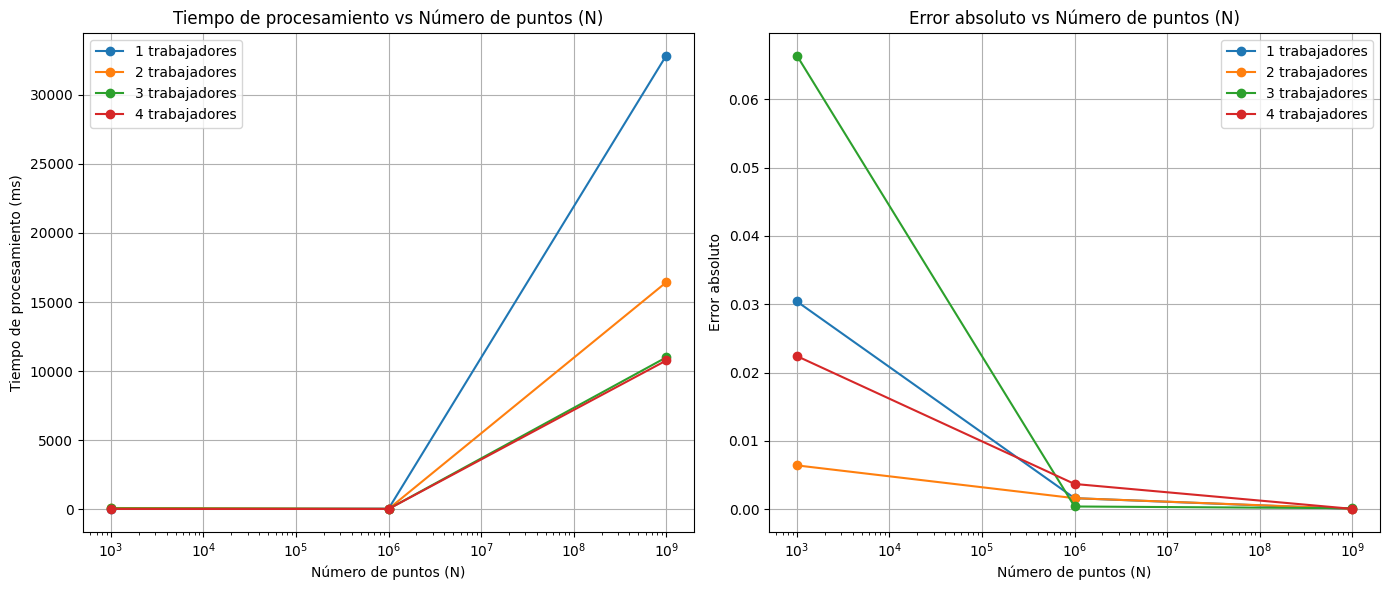

In [1]:
# @title Gráficas

import matplotlib.pyplot as plt
import numpy as np

# Datos de las pruebas
# Número de puntos
N_values = [1000, 1000000, 1000000000]

# Tiempo de procesamiento para diferentes trabajadores
# [1 trabajador, 2 trabajadores, 3 trabajadores, 4 trabajadores]
time_taken = {
    1: [38, 41, 32846],
    2: [90, 26, 16431],
    3: [64, 23, 10994],
    4: [23, 21, 10769]
}

# Estimaciones de π
pi_estimations = {
    1: [3.172, 3.1432, 3.141622932],
    2: [3.148, 3.1432, 3.141655964],
    3: [3.208, 3.141984, 3.141453824],
    4: [3.164, 3.14528, 3.141635972]
}

# Errores absolutos
absolute_errors = {
    1: [0.030407346410207037, 0.0016073464102071, 3.0278410207085216E-5],
    2: [0.0064073464102070155, 0.0016073464102071, 6.331041020679606E-5],
    3: [0.06640734641020707, 3.913464102067721E-4, 1.388295897930547E-4],
    4: [0.02240734641020703, 0.0036873464102069597, 4.3318410206882874E-5]
}

# Graficar tiempo de ejecución
plt.figure(figsize=(14, 6))

# Gráfico 1: Tiempo de procesamiento vs N para diferentes n
plt.subplot(1, 2, 1)
for n, times in time_taken.items():
    plt.plot(N_values, times, marker='o', label=f'{n} trabajadores')

plt.xscale('log')  # Escala logarítmica para N
plt.xlabel('Número de puntos (N)')
plt.ylabel('Tiempo de procesamiento (ms)')
plt.title('Tiempo de procesamiento vs Número de puntos (N)')
plt.legend()
plt.grid(True)

# Gráfico 2: Error absoluto vs N para diferentes n
plt.subplot(1, 2, 2)
for n, errors in absolute_errors.items():
    plt.plot(N_values, errors, marker='o', label=f'{n} trabajadores')

plt.xscale('log')  # Escala logarítmica para N
plt.xlabel('Número de puntos (N)')
plt.ylabel('Error absoluto')
plt.title('Error absoluto vs Número de puntos (N)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### 8. **Conclusiones**

Con los resultados obtenidos de las pruebas de rendimiento, se pueden extraer varias conclusiones sobre la eficiencia del sistema y la precisión en la estimación de π:

1. **Impacto del Número de Puntos (N)**:
   - A medida que el número de puntos $ N $ aumenta, la estimación de π se vuelve más precisa, como era de esperarse. Esto se debe a que un mayor número de puntos permite que el método de Monte Carlo se acerque mejor al valor real de π, reduciendo el error absoluto.
   - Sin embargo, el tiempo de procesamiento también crece significativamente cuando se incrementa $ N $. Esto es especialmente evidente en el caso de $ N = 10^9 $, donde el tiempo de cálculo es considerablemente mayor en comparación con $ N = 10^3 $ o $ N = 10^6 $. Este incremento de tiempo es un reflejo directo de la cantidad de cálculos que cada trabajador debe realizar para estimar π.

2. **Distribución de Tareas y Eficiencia de los Trabajadores**:
   - El uso de múltiples trabajadores ayuda a reducir el tiempo de procesamiento para $ N $ grandes. Con $ N = 10^9 $, el tiempo de ejecución con 4 trabajadores es significativamente menor que con un solo trabajador. Esto demuestra la eficiencia del sistema al distribuir la carga de trabajo entre diferentes nodos.
   - Sin embargo, para $ N $ pequeños, como $ N = 10^3 $, la ventaja de usar múltiples trabajadores no es tan evidente. En estos casos, el costo de coordinar a los trabajadores puede superar los beneficios de la paralelización, resultando en tiempos de ejecución similares o incluso mayores cuando se utilizan más trabajadores.

3. **Optimización del Número de Trabajadores**:
   - En configuraciones de pruebas con $ N = 10^9 $, se observa una disminución significativa del tiempo de ejecución al pasar de 1 a 2 trabajadores, y una mejora adicional aunque menos pronunciada al aumentar a 3 y 4 trabajadores. Esto sugiere que el uso de hasta 4 trabajadores es beneficioso para los valores de $ N $ considerados.

4. **Precisión en la Estimación de π**:
   - El error absoluto disminuye notablemente con el incremento de $ N $, lo que indica una estimación más precisa de π. Para $ N = 10^9 $, el error se reduce a menos de $ 10^{-5} $, lo que muestra la eficacia del método Monte Carlo cuando se cuenta con suficientes puntos.
   - La variabilidad en el error también es influenciada por el número de trabajadores, ya que la distribución de tareas y la forma en que los puntos se generan pueden introducir pequeñas variaciones en los resultados, especialmente en pruebas con menor cantidad de puntos.

En conclusión, el sistema de estimación de π mediante el método de Monte Carlo muestra una buena capacidad de paralelización, siendo especialmente eficiente para grandes volúmenes de puntos. El número óptimo de trabajadores depende de la escala de $ N $; para problemas pequeños, un único trabajador es suficiente, mientras que para $ N $ muy grandes, la distribución de la carga entre varios trabajadores permite aprovechar mejor los recursos computacionales disponibles.

### 9. Anexos

1. **Repositorio de Github**: https://github.com/EstebanGZam/distributed-monte-carlo-method

2. **Diagrama de Clases**: https://drive.google.com/file/d/130opghFO_CC8uOPaXfDTjsrPmftYFzPq/view?usp=sharing

3. **Informe en Colab**: https://colab.research.google.com/drive/1Qh1I10g8B5FwsckaF6bL32RhkrDKjezV?usp=sharing